<a href="https://colab.research.google.com/github/s853348481/MDA/blob/main/%2BLDA_Obama_specch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Data

* Create '**document**' which contains the script of each speech and index number. 








In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/speeches_df.csv");
documents = data[['content']]
documents['index'] = documents.index

documents.head()

,content,index
0,"On behalf of the great state of Illinois, crossroads of a nation, Land of Lincoln, let me expre...",0
1,"Senator Obama: Thank you very much, Mr. President; Ladies and Gentlemen of the Senate: I have t...",1
2,"Good morning President Taylor, Board of Trustees, faculty, parents, family, friends, the commun...",2
3,"] Mr. President, today the nation mourns a genuine American hero. As most of you know, Rosa Park...",3
4,"Thank you very much, Mr. President. You know, four years ago, following the most devastating at...",4


## Text Cleaning

* Import libaries
* Build Text-cleaning pipeline
  * remove stopwords 
  * remove words that has length <3
  * lematize and stemming
* Take a look of the change: 
    * Original document vs After-cleaning document 
* Apply pipeline
* Get '**processed_docs**'

In [2]:
###
import nltk
stemmer = nltk.PorterStemmer()
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
###
from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem.porter import *
nltk.download('omw-1.4')
import numpy as np
np.random.seed(2018)

nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
#pipeline
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
doc_sample = documents[documents['index'] == 200].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words[:10])
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample)[:10])

original document: 
['', 'Thank', 'you,', 'everybody.', 'Please', '--', 'Please', 'have', 'a', 'seat.']


 tokenized and lemmatized document: 
['thank', 'everybodi', 'seat', 'good', 'afternoon', 'everybodi', 'begin', 'thank', 'vice', 'presid']


In [5]:
processed_docs = documents['content'].map(preprocess)
processed_docs[:10]

0    [behalf, great, state, illinoi, crossroad, nat...
1    [senat, obama, thank, presid, ladi, gentlemen,...
2    [good, morn, presid, taylor, board, truste, fa...
3    [presid, today, nation, mourn, genuin, america...
4    [thank, presid, know, year, follow, devast, at...
5    [edit, continu, thank, presid, today, mourn, p...
6    [presid, rise, today, humbl, honor, opportun, ...
7    [know, month, think, hard, plan, run, presid, ...
8    [hello, springfield, look, look, good, thank, ...
9    [presid, rise, offer, strong, word, support, s...
Name: content, dtype: object

## LDA Model

* Preparation before running LDA model
  * Create '**dictionary**', which tags each word with ID based on its location.
  * Remove words that appear less tha 50% but more than 2 different speeches.
  * Create '**bow_corpus**', which includes dict_ID and frequency.
* Fit the model and see the result
  * Baseline LDA model
  * TF-IDF LDA model

In [6]:
#
dictionary = gensim.corpora.Dictionary(processed_docs)
from itertools import islice
def take(n, iterable):
   return list(islice(iterable, n))
take(10,dictionary.items())
#
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=1000)
#
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[0][:5]

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1)]

In [57]:
#Take a look
bow_doc_200 = bow_corpus[200]
for i in range(5):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_200[i][0], 
                                               dictionary[bow_doc_200[i][0]], 
                                     bow_doc_200[i][1]))


Word 0 ("abid") appears 1 time.
Word 1 ("absolut") appears 1 time.
Word 3 ("act") appears 1 time.
Word 11 ("assembl") appears 1 time.
Word 15 ("base") appears 1 time.


''

In [59]:
%%capture --no-display
#
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
#for doc in corpus_tfidf:
#    print(doc)
#    break
#fits baseline LDA_model
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=2, workers=2,random_state=np.random.RandomState(10))

In [60]:
#Topics
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.008*"democraci" + 0.006*"faith" + 0.005*"global" + 0.005*"societi" + 0.004*"immigr" + 0.004*"muslim" + 0.004*"elect" + 0.004*"civil" + 0.004*"stori" + 0.004*"choos"
Topic: 1 
Words: 0.008*"veteran" + 0.006*"properti" + 0.006*"reserv" + 0.006*"compani" + 0.006*"energi" + 0.005*"ccoomm" + 0.005*"folk" + 0.005*"iraq" + 0.005*"militari" + 0.004*"obama"
Topic: 2 
Words: 0.013*"obama" + 0.009*"israel" + 0.007*"nuclear" + 0.006*"republican" + 0.006*"insur" + 0.005*"china" + 0.005*"energi" + 0.005*"reform" + 0.005*"intern" + 0.005*"actual"
Topic: 3 
Words: 0.009*"iran" + 0.009*"obama" + 0.008*"militari" + 0.007*"deal" + 0.007*"isil" + 0.007*"intern" + 0.007*"nuclear" + 0.007*"terrorist" + 0.006*"region" + 0.005*"weapon"
Topic: 4 
Words: 0.008*"school" + 0.006*"colleg" + 0.006*"student" + 0.005*"obama" + 0.005*"iraq" + 0.005*"class" + 0.005*"worker" + 0.004*"program" + 0.004*"folk" + 0.004*"high"
Topic: 5 
Words: 0.012*"insur" + 0.010*"obama" + 0.007*"governor" + 0.006*"vote"

In [62]:
%%capture --no-display
#fits LDA_model_tfidf
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

## Topics Visualization

* Create two table based on result of LDA model
  * table1 shows:
    * Speech No.
    * Corresponding dominant topic No.
    * Percent of contribution of dominant topic
    * keywords and Text
  * table2 shows:
    * Topic No.
    * Keyword
    * Most represitve text (Most examplar sentense for each topic)
* Vistualization
  * Frenquency of the topic as the dominant topic 
  * Word-Cloud with the size of the words proportional to the weight
  * Change of topics along with time
  * pyLDAvis
    * Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
    * Blue bars represent the overall frequency of each word in the corpus.
    * Red bars give the estimated number of times a given term was generated by a given topic.
    * The further the bubbles are away from each other, the more different they are

In [11]:
#generate Table 1
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=data):    
    sent_topics_df = pd.DataFrame()    
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)
  #Changes columns name
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.6319,"democraci, faith, global, societi, immigr, mus...","[behalf, great, state, illinoi, crossroad, nat..."
1,1,0.0,0.6959,"democraci, faith, global, societi, immigr, mus...","[senat, obama, thank, presid, ladi, gentlemen,..."
2,2,4.0,0.6843,"school, colleg, student, obama, iraq, class, w...","[good, morn, presid, taylor, board, truste, fa..."
3,3,0.0,0.7417,"democraci, faith, global, societi, immigr, mus...","[presid, today, nation, mourn, genuin, america..."
4,4,5.0,0.4670,"insur, obama, governor, vote, republican, folk...","[thank, presid, know, year, follow, devast, at..."
...,...,...,...,...,...
95,95,5.0,0.5414,"insur, obama, governor, vote, republican, folk...","[thank, board, member, honor, guest, love, lad..."
96,96,0.0,0.7739,"democraci, faith, global, societi, immigr, mus...","[thank, everybodi, seat, good, morn, everybodi..."
97,97,0.0,0.5102,"democraci, faith, global, societi, immigr, mus...","[good, morn, wonder, unit, state, militari, ac..."
98,98,1.0,0.5622,"veteran, properti, reserv, compani, energi, cc...","[good, afternoon, everybodi, question, want, u..."


In [12]:
#generate Table2
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)   
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
sent_topics_sorteddf_mallet.head(10)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9992,"democraci, faith, global, societi, immigr, muslim, elect, civil, stori, choos","[thank, thank, madam, chairwoman, dlamini, zuma, thank, kind, word, leadership, prime, minist, h..."
1,1.0,0.9988,"veteran, properti, reserv, compani, energi, ccoomm, folk, iraq, militari, obama","[hello, legionnair, wonder, thank, command, foster, introduct, lifetim, servic, fellow, marin, s..."
2,2.0,0.9275,"obama, israel, nuclear, republican, insur, china, energi, reform, intern, actual","[presid, obama, good, afternoon, everybodi, seat, want, welcom, presid, white, hous, host, year,..."
3,3.0,0.9992,"iran, obama, militari, deal, isil, intern, nuclear, terrorist, region, weapon","[presid, obama, presid, holland, honor, welcom, white, hous, happier, time, american, stand, fri..."
4,4.0,0.9990,"school, colleg, student, obama, iraq, class, worker, program, folk, high","[everybodi, seat, thank, wonder, introduct, david, thank, great, work, appreci, warm, welcom, ge..."
5,5.0,0.9997,"insur, obama, governor, vote, republican, folk, compani, percent, afford, money","[microsoft, word, obama, romney, live, debat, barack, obama, mitt, romney, presidenti, candid, d..."


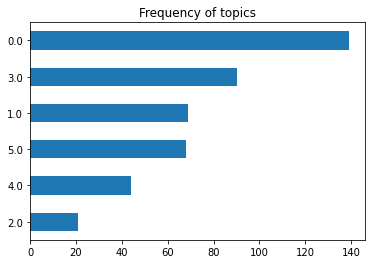

In [13]:
#Frequency Table
import matplotlib.pyplot as plt
df_dominant_topic["Dominant_Topic"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of topics")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


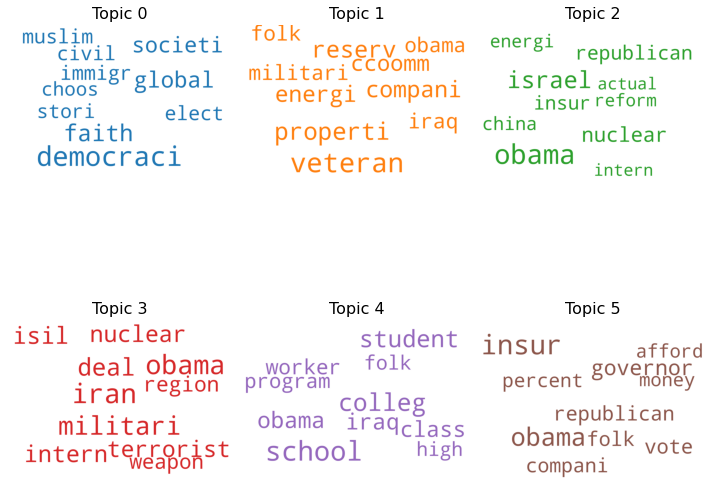

In [14]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [69]:
%%capture --no-display
!pip install pyLDAvis

In [72]:
#pyLDAvis
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,bow_corpus,dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.031893 -0.014179       1        1  24.468479
0      0.004671  0.031362       2        1  23.168482
5     -0.030349 -0.012617       3        1  20.329899
1      0.006246 -0.000352       4        1  11.899260
4     -0.011261  0.007956       5        1  11.407535
2     -0.001200 -0.012170       6        1   8.726344, topic_info=         Term         Freq        Total Category  logprob  loglift
706    israel   438.000000   438.000000  Default  30.0000  30.0000
663     insur   969.000000   969.000000  Default  29.0000  29.0000
256     obama  1687.000000  1687.000000  Default  28.0000  28.0000
686   veteran   435.000000   435.000000  Default  27.0000  27.0000
705      iran   884.000000   884.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
90   governor    71.648118   640.373480   Topic6  -5.6614   0.2485
313   develop    74.562474   698.551331   Topic6  -5.6216   0.2015
388   program    73.961361   767.192950   Topic6  -5.6297   0.0996
691    weapon    67.733364   627.933447   Topic6  -5.7176   0.2120
85       folk    68.169226   859.752935   Topic6  -5.7112  -0.0958

[374 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
283       1  0.190615  actual
283       2  0.136812  actual
283       3  0.345874  actual
283       4  0.086084  actual
283       5  0.098382  actual
...     ...       ...     ...
229       2  0.480037   youth
229       3  0.166969   youth
229       4  0.052178   youth
229       5  0.093920   youth
229       6  0.073049   youth

[1554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 2, 5, 3])

## Sentiment Analysis


* Use textblob to generate two features for each speech
  * polarity [-1,1]
    * smaller than 0  => negative
    * bigger than 0 => positive
      * bigger than 0 & smaller than 0.15 (median) => less postive
      * equal to 0.15 => positive
      * bigger than 0.15 =>very positive
  * subjectivity [0,1]
    * smaller than 0.5  => objective
    * bigger than 0.5 => subjective



In [65]:
#use Textblob to generate two features 'polarity' and 'subjectivity'
from textblob import TextBlob
list_do=range(len(documents))
documents["polarity"]=list_do
documents["subjectivity"]=list_do
i=0
for i in range(0,len(documents)):
  a=TextBlob(documents["content"][i]).sentiment.polarity
  format_float = "{:.2f}".format(a)
  documents["polarity"][i]=format_float
  a=TextBlob(documents["content"][i]).sentiment.subjectivity
  format_float = "{:.2f}".format(a)
  documents["subjectivity"][i]=format_float
documents["date"] =data[['date']]
documents.head()
warnings.filterwarnings('ignore')

In [75]:
#Feature Engineering and visualzation
  #sentiment
warnings.filterwarnings('ignore')
documents["sentiment"]=list_do
documents.head()
for i in range(0,len(documents)):
  documents['polarity'].iloc[i]=float(documents['polarity'].iloc[i])
  if documents["polarity"].iloc[i] < 0.15:
    documents["sentiment"].iloc[i]='less positive'
  elif documents["polarity"].iloc[i] == 0.15:
    documents["sentiment"].iloc[i]='positive'
  else :
    documents["sentiment"].iloc[i]='very positive'
  #'dominant topics'
documents["topic"] =list_do
documents["topic"]=df_dominant_topic["Dominant_Topic"]
  #'year'
documents['date'] = pd.to_datetime(documents['date'])
documents['year'] = documents['date'].dt.year
documents.head()

,content,index,polarity,subjectivity,date,sentiment,topic,year
0,"On behalf of the great state of Illinois, crossroads of a nation, Land of Lincoln, let me expre...",0,0.15,0.41,2004-07-27,positive,0.0,2004
1,"Senator Obama: Thank you very much, Mr. President; Ladies and Gentlemen of the Senate: I have t...",1,0.18,0.57,2005-01-06,very positive,0.0,2005
2,"Good morning President Taylor, Board of Trustees, faculty, parents, family, friends, the commun...",2,0.14,0.46,2005-06-04,less positive,4.0,2005
3,"] Mr. President, today the nation mourns a genuine American hero. As most of you know, Rosa Park...",3,0.09,0.45,2005-10-25,less positive,0.0,2005
4,"Thank you very much, Mr. President. You know, four years ago, following the most devastating at...",4,0.09,0.47,2005-12-15,less positive,5.0,2005


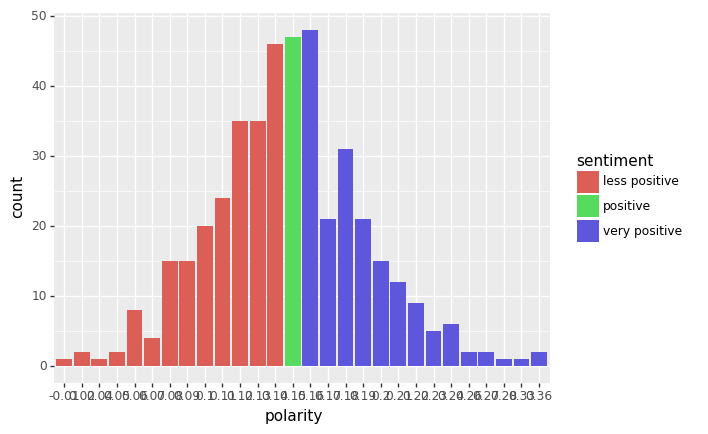

<ggplot: (8768329337869)>

In [74]:
from plotnine import ggplot, aes, geom_bar, geom_text, geom_density
#The median value of polarity 0.15 seprates dataset into two parts with similar size
warnings.filterwarnings('ignore')
ggplot(documents)+aes(x ='polarity',fill = 'sentiment')+geom_bar(stat = "count")


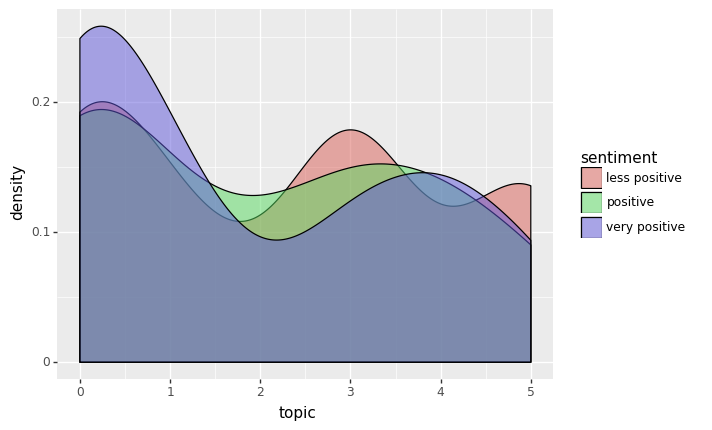

<ggplot: (8768329906157)>

In [73]:
#polarity catogories of each topics 
warnings.filterwarnings('ignore')
ggplot(documents)+aes(x = 'topic',fill = 'sentiment' )+geom_density(alpha =0.5)


## Outside sources

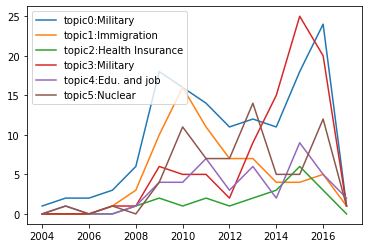

In [22]:
#data_visual

df2 = documents.groupby(['topic','year']).size().unstack(fill_value=0).stack().to_frame().reset_index()
df2.columns = ['topic','year','count']
count1 = list(df2[df2['topic']==0]['count'])
count2 = list(df2[df2['topic']==1]['count'])
count3 = list(df2[df2['topic']==2]['count'])
count4 = list(df2[df2['topic']==3]['count'])
count5 = list(df2[df2['topic']==4]['count'])
count6 = list(df2[df2['topic']==5]['count'])

year = list(df2[df2['topic']==1]['year'])
plt.plot(year,count1,label='topic0:Military')
plt.plot(year,count2,label='topic1:Immigration')
plt.plot(year,count3,label='topic2:Health Insurance')
plt.plot(year,count4,label='topic3:Military')
plt.plot(year,count5,label='topic4:Edu. and job')
plt.plot(year,count6,label='topic5:Nuclear')
plt.legend()
plt.show()


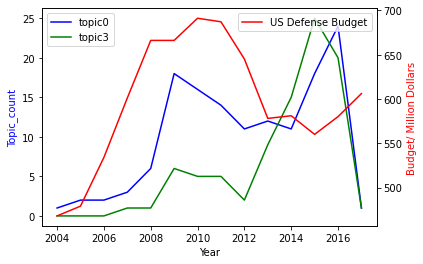

In [23]:
#plot1 Denfense Budget
extra1=pd.read_csv('https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/USA-Defense-Budget.csv',header=None)
extra1.columns=['year','count']
_,ax=plt.subplots()
ax.plot(year,count1,'b',label='topic0')
ax.plot(year,count4,'g',label='topic3')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')
ax2 = ax.twinx()
ax2.plot(year,extra1['count'],'r',label='US Defense Budget')
ax2.set_ylabel('Budget/ Million Dollars',color='r')
plt.legend(loc=1)
plt.show()

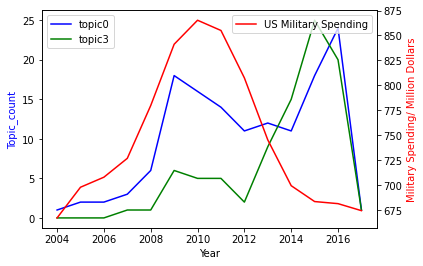

In [24]:
#extra variates-US Military Spending
extra2=pd.read_csv('https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/USA-Military-Spending.csv',header=None)
extra2.columns=['year','military']
#plot2 Military Spending
_,ax=plt.subplots()
ax.plot(year,count1,'b',label='topic0')
ax.plot(year,count4,'g',label='topic3')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')
ax2 = ax.twinx()
ax2.plot(year,extra2['military'],'r',label='US Military Spending')
ax2.set_ylabel('Military Spending/ Million Dollars',color='r')
plt.legend(loc=1)
plt.show()

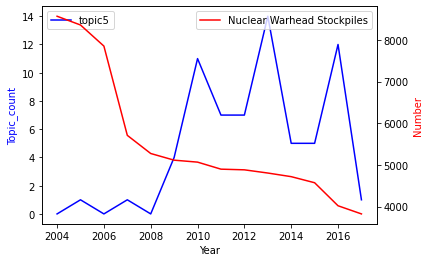

In [25]:
#extra variates-US Nuclear Warhead Stockpiles
extra3=pd.read_csv('https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/USA-Nuclear-Warhead-Stockpiles.csv',header=None)
extra3.columns=['a','a','year','nuclear']
#plot3 Nuclear Warhead Stockpiles
_,ax=plt.subplots()
ax.plot(year,count6,'b',label='topic5')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')
ax2 = ax.twinx()
ax2.plot(year,extra3['nuclear'],'r',label='Nuclear Warhead Stockpiles')
ax2.set_ylabel('Number',color='r')
plt.legend(loc=1)
plt.show()

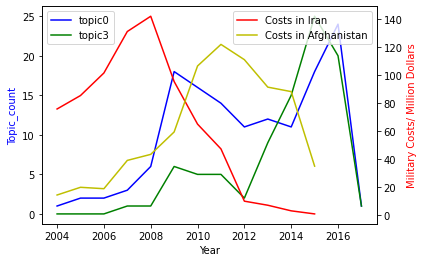

In [26]:
#plot4 US costs in Iran and Afghanistan
extra4=pd.read_csv('https://raw.githubusercontent.com/s853348481/MDA/main/MDA_datasets/US%20costs%20in%20Iran%20and%20Afghanistan.csv',header=None)
extra4.columns=['year','Iran','Afghanistan']
_,ax=plt.subplots()
ax.plot(year,count1,'b',label='topic0')
ax.plot(year,count4,'g',label='topic3')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')
ax2 = ax.twinx()
ax2.plot(extra4['year'],extra4['Iran'],'r',label='Costs in Iran')
ax2.plot(extra4['year'],extra4['Afghanistan'],'y',label='Costs in Afghanistan')
ax2.set_ylabel('Military Costs/ Million Dollars',color='r')
plt.legend(loc=1)
plt.show()

In [27]:
#extra variates-Employment Rate
column_employment_rate=['62.3','62.7','63.1','63','62.2','59.3','58.5','58.4','58.6','58.6','59','59.3','59.7','60.1']
extra6=np.float64(column_employment_rate)
print(extra6)

[62.3 62.7 63.1 63.  62.2 59.3 58.5 58.4 58.6 58.6 59.  59.3 59.7 60.1]


In [28]:
#extra variates-Immigrants as Percentage of the U.S. Population
column_immigrants_percentage=['11.8','12','12.1','12.3','12.3','12.4','12.9','13','13','13.1','13.3','13.5','13.5','13.7']
extra7=np.float64(column_immigrants_percentage)
print(extra7)

[11.8 12.  12.1 12.3 12.3 12.4 12.9 13.  13.  13.1 13.3 13.5 13.5 13.7]


In [29]:
#extra variates-Number of Immigrants
column_immigrants_number=['468', '479', '534', '601', '666', '666', '691', '687', '645', '578', '581', '560', '580', '606']
extra8=np.float64(column_immigrants_number)
print(extra8)

[468. 479. 534. 601. 666. 666. 691. 687. 645. 578. 581. 560. 580. 606.]


In [30]:
#extra variates-Number of people with health insurance in the United States
column_health_insurance_number=['249.41', '250.8', '251.61', '255.02', '256.7', '255.3', '256.6', '260.21', '263.17', '271.61', '283.2', '289.9', '292.3', '296.9']
extra9=np.float64(column_health_insurance_number)
print(extra9)

[249.41 250.8  251.61 255.02 256.7  255.3  256.6  260.21 263.17 271.61
 283.2  289.9  292.3  296.9 ]


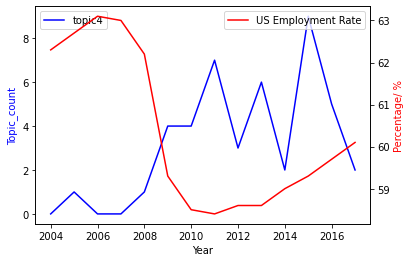

In [31]:
#plot5 Employment Rate
_,ax=plt.subplots()
ax.plot(year,count5,'b',label='topic4')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')

ax2 = ax.twinx()
ax2.plot(year,extra6,'r',label='US Employment Rate')
ax2.set_ylabel('Percentage/ %',color='r')
plt.legend(loc=1)
plt.show()

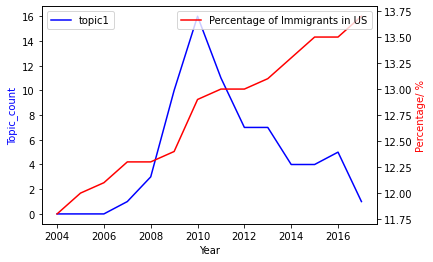

In [32]:
#plot6 Immigrants as Percentage of the U.S. Population 
_,ax=plt.subplots()
ax.plot(year,count2,'b',label='topic1')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')

ax2 = ax.twinx()
ax2.plot(year,extra7,'r',label='Percentage of Immigrants in US')
ax2.set_ylabel('Percentage/ %',color='r')
plt.legend(loc=1)
plt.show()
#Analyze the change in the slope of the red line

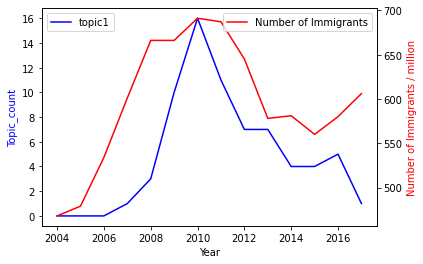

In [33]:
#plot7 Number of Immigrants
_,ax=plt.subplots()
ax.plot(year,count2,'b',label='topic1')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')

ax2 = ax.twinx()
ax2.plot(year,extra8,'r',label='Number of Immigrants')
ax2.set_ylabel('Number of Immigrants / million',color='r')
plt.legend(loc=1)
plt.show()
#Analyze the change in the slope of the red line

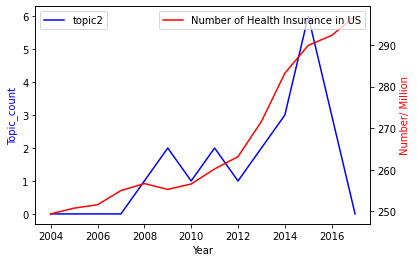

In [34]:
#plot8 Number of people with health insurance in the United States
_,ax=plt.subplots()
ax.plot(year,count3,'b',label='topic2')
plt.legend(loc=2)
ax.set_xlabel('Year')
ax.set_ylabel('Topic_count',color='b')

ax2 = ax.twinx()
ax2.plot(year,extra9,'r',label='Number of Health Insurance in US')
ax2.set_ylabel('Number/ Million',color='r')
plt.legend(loc=1)
plt.show()
#Analyze the change in the slope of the red line

In [42]:
pip freeze

absl-py==1.2.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==2.1.9
autograd==1.4
Babel==2.10.3
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.8
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.8
certifi==2022.6.15
cffi==1.15.1
cftime==1.6.1
chardet==3.0.4
charset-normalizer==2.1.0
click==7.1.2
clikit==0.6.2
cloudpickle==1.3.0
cmake==3.22.6
cmdstanpy==1.0.4
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.3.0
cvxpy==1.2.1
cycler==0.11.0
cymem==2.0.6
Cython==0.29.32
daft==0.0.4
dask==2.12.0
datascience==0.17.5
debugpy==1.0.0
decora

SyntaxError: ignored